In [1]:
using Flight
using ControlSystems

In [67]:
ac = Cessna172Rv0(NED()) |> System #must use NED kinematics
ac.u.airframe.pld.m_pilot = 75
ac.u.airframe.pld.m_copilot = 75
ac.u.airframe.pld.m_lpass = 0
ac.u.airframe.pld.m_rpass = 0
ac.u.airframe.pld.m_baggage = 0

trim_params = C172Rv0.TrimParameters(
    loc = LatLon(),
    h = HOrth(1000),
    ψ_nb = 0.0,
    TAS = 40.0,
    γ_wOb_n = 0.0,
    ψ_lb_dot = 0.00,
    θ_lb_dot = 0.0,
    β_a = 0.0,
    fuel = 1,
    mixture = 0.5,
    flaps = 0.0)

lm = linearize!(ac; trim_params)

LinearStateSpace{16, 4, 17, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(ψ = 1, θ = 2, φ = 3, ϕ = 4, λ = 5, h = 6, p = 7, q = 8, r = 9, v_x = 10, v_y = 11, v_z = 12, α_filt = 13, β_filt = 14, ω_eng = 15, fuel = 16)}}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(throttle = 1, aileron = 2, elevator = 3, rudder = 4)}}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(ψ = 1, θ = 2, φ = 3, ϕ = 4, λ = 5, h = 6, p = 7, q = 8, r = 9, TAS = 10, α = 11, β = 12, f_x = 13, f_y = 14, f_z = 15, ω_eng = 16, m_fuel = 17)}}}, ComponentArrays.ComponentMatrix{Float64, Matrix{Float64}, Tuple{ComponentArrays.Axis{(ψ = 1, θ = 2, φ = 3, ϕ = 4, λ = 5, h = 6, p = 7, q = 8, r = 9, v_x = 10, v_y = 11, v_z = 12, α_filt = 13, β_filt = 14, ω_eng = 15, fuel = 16)}, ComponentArrays.Axis{(ψ = 1, θ = 2, φ = 3, ϕ = 4, λ = 5, h = 6, p = 7, q = 8, r = 9, v_x = 10, v_y = 11, v_z = 12, α_filt = 13, β_fil

In [68]:
long_dyn = filter(lm;
    u = (:elevator, :throttle),
    x = (:v_x, :v_z, :θ, :q, :α_filt, :ω_eng),
    y = (:q, :θ, :α, :TAS, :f_x, :f_z, :ω_eng))

long_dyn_ss = long_dyn |> ss
long_dyn_tf = long_dyn_ss |> tf

#could reduce the model further for CAS by omitting omega_eng and throttle
pitch_dyn = filter(lm; u = (:elevator,),
    x = (:v_x, :v_z, :θ, :q, :α_filt),
    y = (:q, :θ, :α, :TAS))

pitch_dyn_ss = pitch_dyn |> ss
pitch_dyn_tf = pitch_dyn_ss |> tf


TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
Input 1 to output 1
    9.27084426946277s^4 + 214.47680326838804s^3 + 607.4998103562757s^2 + 53.24773068633979s + 0.0009054213086301388
------------------------------------------------------------------------------------------------------------------------
1.0s^5 + 28.428034153747042s^4 + 273.26688925460655s^3 + 1292.7076874138897s^2 + 131.84006460336312s + 98.77337689055378

Input 1 to output 2
   -3.552713678800501e-15s^4 + 9.075885481767273s^3 + 209.96651911580852s^2 + 594.7245223122839s + 52.12756227651536
------------------------------------------------------------------------------------------------------------------------
1.0s^5 + 28.428034153747042s^4 + 273.26688925460655s^3 + 1292.7076874138897s^2 + 131.84006460336312s + 98.77337689055378

Input 1 to output 3
    0.10266104308111679s^4 + 11.451786214653566s^3 + 188.9343347875615s^2 + 20.31066109264762s + 21.002131078350942
----------------------------------

In [97]:
#extract the elevator to q transfer function
e2q = long_dyn_tf[1,1]
@show zpk(e2q)

#the open loop TF is type 0, but with a zero almost at the origin, so in
#practice it has nearly derivative action. we can see that the steady state
#error for a step input is nearly 1, that is, the output falls back almost to
#zero
err_e2q = 1/(1+e2q)
@show zpk(err_e2q)
@show err_e2q(0)

#therefore, although adding a pure integrator will in theory yield a type 1
#system (and zero steady state error for step inputs), in practice (for
#reasonable time windows) it will still behave as a type 0. so, in addition to
#this integrator we can expect to require some more integral action in the
#feedforward path for satisfactory response.


zpk(e2q) = TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                           (1.0s + 19.84755350362755)(1.0s + 9.679477907117613)(1.0s + 3.1964561793195556)(1.0s + 0.05568806322276216)(1.0s + 2.754422049588953e-5)
9.270844269462778-------------------------------------------------------------------------------------------------------------------------------------------------------------
                 (1.0s + 16.652259873368457)(1.0s + 9.678912530164663)(1.0s^2 + 11.688544157047549s + 76.06252996958894)(1.0s^2 + 0.052971548503113926s + 0.08249096058444758)

Continuous-time transfer function model


zpk(err_e2q) = TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
   (1.0s + 16.652259873368457)(1.0s + 9.678912530164663)(1.0s^2 + 11.688544157047549s + 76.06252996958894)(1.0s^2 + 0.052971548503113926s + 0.08249096058444758)
1.0-------------------------------------------------------------------------------------------------------------------------------------------------------------
   (1.0s^2 + 30.927495829539836s + 277.6904024842916)(1.0s + 9.680512702177786)(1.0s + 6.684389613941575)(1.0s^2 + 0.051134232887361394s + 0.056280719094592986)

Continuous-time transfer function model
err_e2q(0) = [0.9999913650677842;;]


1×1 Matrix{Float64}:
 0.9999913650677842

ss_err_step = e2q_c_err(0) = [0.0;;]
ss_err_ramp = (tf(1, [1, 0]) * e2q_c_err)(0) = [Inf;;]


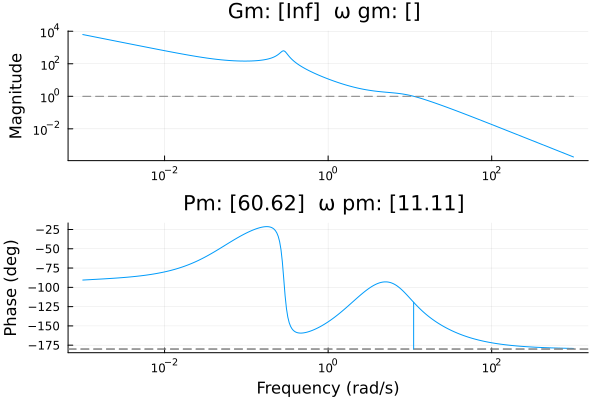

In [86]:
#we can start by trying a PID in series with the pure integrator previously
#indicated. rather than aiming for minimum steady state error (since the outward
#θ loop doesn't really care for that), we want reasonable stability margins

# k_p = 20
# k_i = 5
# k_d = 0.5
k_p = 10
k_i = 20
k_d = 0.5
q_comp = series(k_p + k_i * tf(1, [1,0]) + k_d * tf([1, 0], [0.05, 1]), tf(1, [1, 0]))
    
e2q_c = series(q_comp, e2q)

#error transfer function (setpoint - plant output)
e2q_c_err = 1/(1+e2q_c)
#the steady state error for a given test input is the final value of the ETF for
#that input. applying the final value theorem, the final value for a step input
#is found simply by settng s=0. therefore:
@show ss_err_step = e2q_c_err(0)

#and for a ramp input:
@show ss_err_ramp = (tf(1, [1, 0]) * e2q_c_err)(0)

# marginplot(e2q * tf(1, [1, 0]))
marginplot(e2q_c)


zpk(cl) = TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                          (1.0s + 19.847553503627594)(1.0s + 9.67947790711759)(1.0s + 8.701562118716474)(1.0s + 3.1964561793195196)(1.0s + 2.298437881283603)(1.0s + 0.05568806322276219)(1.0s + 2.7544220495889538e-5)
185.41688538925555---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                  (1.0s + 19.89867315377218)(1.0s^2 + 13.010005375644496s + 211.35109865584903)(1.0s + 12.106378548880116)(1.0s + 9.678743021640653)(1.0s^2 + 3.323681610130177s + 4.663721764579456)(1.0s + 0.05517885467456137)(1.0s + 2.7544341560595938e-5)

Continuous-time transfer function model
poles(cl) = ComplexF64[-19.89867315377218 + 0.0im, -6.505002687822248 + 13.001386029469103im, -6.505002687822248 - 13.001386029

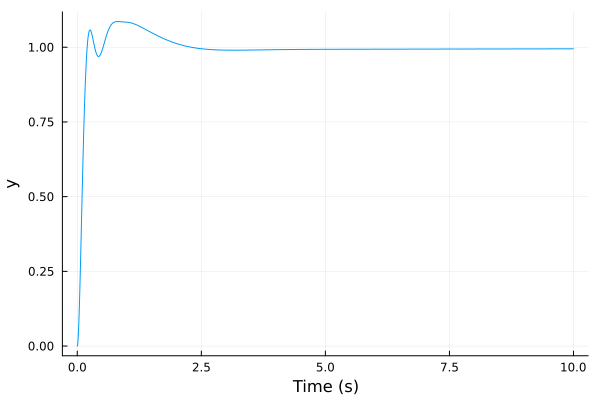

In [90]:
cl = feedback(e2q_c, 1)
@show zpk(cl)
@show poles(cl)
# bodeplot(cl)
step(cl, 10) |> plot

So, now we have a SISO compensator design for q, let's use to close the loop in the MIMO plant. The long_dyn MIMO system has two inputs, elevator and throttle. So we need a MIMO version of our SISO compensator, which will be placed upstream of the MIMO plant, applying the SISO compensator only on the first input and letting the second pass through unchanged to the plant.

The first input to this MIMO compensator will be q_err, and its second input, the throttle input u_t. It must apply the SISO feedforward compensator above to q_err, and a unit gain to u_t. This is achieved as follows:

In [73]:
q_comp_MIMO = append(q_comp, tf(1)) |> ss #should convert to ss before concatenation

StateSpace{Continuous, Float64}
A = 
 0.0  2.0    0.0
 0.0  0.0    8.0
 0.0  0.0  -20.0
B = 
 0.0  0.0
 0.0  0.0
 8.0  0.0
C = 
 3.125  3.4375  2.5
 0.0    0.0     0.0
D = 
 0.0  0.0
 0.0  1.0

Continuous-time state-space model

In [74]:
q_comp_long_dyn = series(q_comp_MIMO, long_dyn_ss) #equivalent to long_dyn_ss * q_comp_MIMO (in the product notation, the second system goes first)

StateSpace{Continuous, Float64}
A = 
 -0.19859680477721456     1.6995383542928197     -9.73831005186861        -1.2001709230983124  -28.270253986086885   0.01655814646030265    -18.24453762126801   -20.06899138339481   -14.595630097014407
 -0.12378018942030156    -4.009748398951633      -0.852678080505477       38.40807910596913     13.896606172334636   0.0004016094008590719   11.217055888089112   12.338761476898023    8.973644710471289
  1.5718954596588518e-7   1.3799921680602862e-8  -1.2124289045913894e-11   0.9789708568714559    0.0                 0.0                      0.0                  0.0                  0.0
  0.2019250006242335     -2.444967004340289      -4.440750577927588e-6    -4.219688950006089    48.73392574869339    0.004388910852074673    28.97138834207113    31.868527176278242   23.177110673656905
 -0.04555407991409217     0.49792049923758624     0.0                      0.0                 -20.0                 0.0                      0.0                  0.0   

The setpoint vector to be applied to the closed-loop MIMO system is r = [q_cmd, u_t]. The input to the MIMO compensator must be e = [q_err, u_t] = r - f = [q_cmd, u_t] - [q, 0]. So we need a matrix gain that premultiplies the 7-component output vector of long_dyn, and produces a 2-component vector [q, 0]. This will be a 2x7 matrix with all entries set to zero except [1, 1] (the nonzero output goes in the first component, and q is the first element in long_dyn's output vector)

zpk(e2q_cl_MIMO) = TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                 (1.0s - 3.727872392621645e15)(1.0s + 19.847553865004706)(1.0s + 9.679451296495435)(1.0s + 8.701594963760728)(1.0s + 3.19643347877074)(1.0s + 2.298454080912269)(1.0s + 0.05568796912357253)(1.0s + 2.754345710078297e-5)
-4.973799150320701e-14----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                      (1.0s + 19.898673153772265)(1.0s^2 + 13.010005375644457s + 211.35109865584846)(1.0s + 12.10637854888047)(1.0s + 9.678743021640344)(1.0s^2 + 3.3236816101301896s + 4.663721764579472)(1.0s + 0.05517885467443744)(1.0s + 2.7544341688858078e-5)

Continuous-time transfer function model


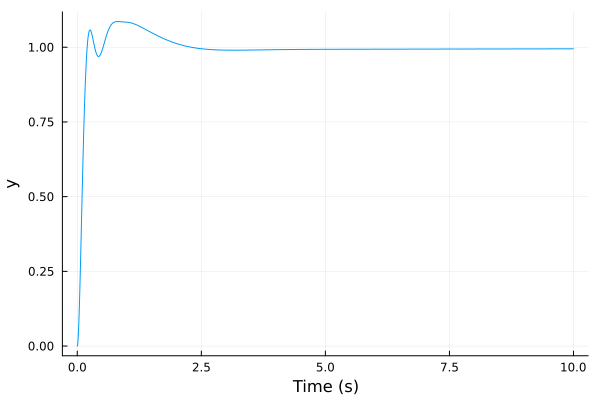

In [75]:
K_select = zeros(2, 7)
K_select[1,1] = 1
K_ss = ss(K_select) #creates a ss with no dynamics and K_select as feedthrough

#now create a feedback loop with K in the feedback path
q_comp_long_dyn_cl = feedback(q_comp_long_dyn, K_ss)

#this is similar, but NOT equivalent: it uses unit feedback, which means that
#the whole 7 component output vector from q_comp_long_dyn is fed back, and then
#multiplied by K_ss (and so reduced to 2 components) in the feedforward path
#before entering the compensator. this yields a 7 input closed loop system, of
#which only the two first inputs actually do anything (the others get discarded
# when they pass through K) q_comp_long_dyn_cl = feedback(series(K_ss,
# q_comp_long_dyn))

e2q_cl_MIMO = (q_comp_long_dyn_cl |> tf)[1,1]

#make sure the zpk data matches that of the SISO closed loop TF
@show zpk(e2q_cl_MIMO)

#check step response
step(e2q_cl_MIMO, 10) |> plot


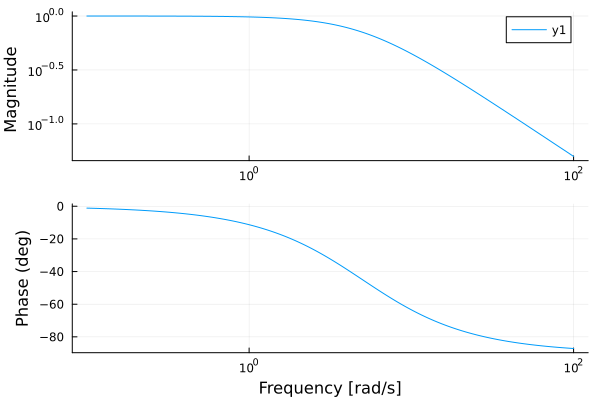

In [76]:
#let's see what we could achieve if we had an actuator in the loop with a 5Hz
#time constant

k_p = 3.4
k_i = 8
k_d = 0.3
q_comp = tf(1, [1, 0]) * (k_p + k_i * tf(1, [1,0]) + k_d * tf([1, 0], [0.05, 1]))
act = tf(1, [0.2, 1])
    
e2q_c = q_comp * act * e2q
cl = feedback(e2q_c, 1)

marginplot(e2q_c)
bodeplot(act)


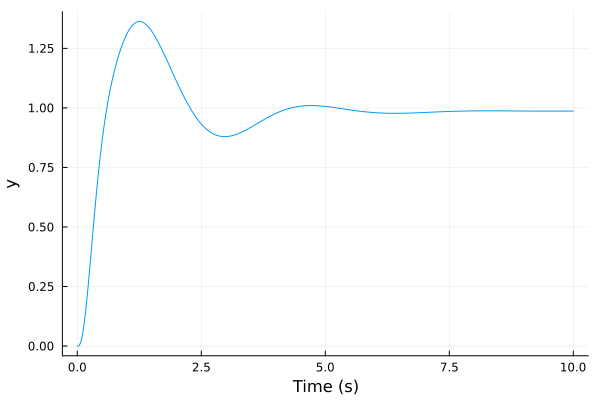

In [78]:
step(cl, 10) |> plot

In [79]:
# world = SimpleWorld(Cessna172Rv0(LTF())) |> System; #for simulation, we use LTF kinematics

In [80]:
# #trim for the trim conditions above and simulate
# (success, result) = trim!(world; trim_params)
# @assert success
# sim = Simulation(world; t_end = 30, adaptive = true)
# Sim.run!(sim, verbose = true)
# # plots = make_plots(sim; Plotting.defaults...)
# plots = make_plots(TimeHistory(sim).ac.kinematics; Plotting.defaults...)
# save_plots(plots, save_folder = joinpath("tmp", "trim_sim_test"))